In [1]:
import array
import itertools
import os
import os.path as op
import PIL
import multiprocessing
print(multiprocessing.cpu_count())
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from tqdm.auto import tqdm

import timescales as fw
import timescales.data as fwd
import timescales.simulation_plasticity as fwsp

128


In [11]:
def extract_patches(img, patch_h, patch_w, sigma, n_steps, rng):
    walk_h, walk_w = fwd.random_walk(n_steps, sigma=sigma, rng=rng)
    h0, w0 = img.shape[0] // 2, img.shape[1] // 2
    walk_h = walk_h + h0
    walk_w = walk_w + w0
    patches = np.array([img[h:h+patch_h, w:w+patch_w] for h, w in zip(walk_h, walk_w)])
    return patches, np.stack((walk_h, walk_w), 1)

def load_image(
    # data_dir: str = "data/vanhateren_imc", 
    data_dir: str = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc", 
    filename = "", 
    crop_size: int = 512, 
    rng  = None,
    )  :
    """Loads randomly cropped img from van hateren dataset."""

    if rng is None:
        rng = np.random.default_rng()

    with open(op.join(data_dir, filename), 'rb') as handle:
        s = handle.read()
        arr = array.array('H', s)
        arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    H, W = img.shape

    rand_h = rng.integers(0, H-crop_size, 1)[0]
    rand_w = rng.integers(0, W-crop_size, 1)[0]
    img = img[rand_h:rand_h + crop_size, rand_w:rand_w + crop_size]
    return img

def image_patches_random_walk(i, patch_h, patch_w, sigma, n_steps, seed):
    rng = np.random.default_rng(seed)
    img = load_image(filename=files[i], rng=rng)
    patches, coords = extract_patches(img, patch_h, patch_w, sigma, n_steps, rng)
    patches = patches.reshape((n_steps, -1))
    cov = np.cov(patches.T)
    return cov


def tile(data_dir, filename, d: int):
    
    with open(op.join(data_dir, filename), 'rb') as handle:
        s = handle.read()
        arr = array.array('H', s)
        arr.byteswap()
    img = np.array(arr, dtype='uint16').reshape(1024, 1536)
    # divide by max int16 value and then cast to float
    img = img / np.iinfo(np.uint16).max
    img = img.astype(np.float32)
    
    w, h = img.shape
    img = PIL.Image.fromarray(img)
    grid = itertools.product(range(0, h-h%d, d), range(0, w-w%d, d))
    patches = []
    for i, j in grid:
        box = (j, i, j+d, i+d)
        patches.append(np.array(img.crop(box)))
    return np.array(patches)

def image_patches_tiled(i):
    patches = tile(data_dir, files[i], patch_h)
    patches = patches.reshape((patches.shape[0], -1))
    cov = np.cov(patches.T)
    return cov

def normalize_cov(C: np.ndarray) -> np.ndarray:
    sigma = np.sqrt(np.diag(C))
    C_hat = C/np.outer(sigma, sigma)
    return C_hat

def plot_two_images(i, j, all_covs, files, vmin=200, vmax=2000):
    fig, ax = plt.subplots(2, 2, sharex='row', sharey='row')
    ax = ax.ravel()
    ax[0].imshow(load_image(filename=files[i], rng=np.random.default_rng(i)), cmap='gray', vmin=vmin, vmax=vmax)
    ax[1].imshow(load_image(filename=files[j], rng=np.random.default_rng(j)), cmap='gray', vmin=vmin, vmax=vmax)
    MAX = 1
    ax[2].imshow(normalize_cov(all_covs[i]), cmap='icefire', vmax=MAX, vmin=-MAX)
    ax[3].imshow(normalize_cov(all_covs[j]), cmap='icefire', vmax=MAX, vmin=-MAX)

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    sns.despine()
    # remove whitespace between columns
    fig.subplots_adjust(wspace=-.5, hspace=0)
    fig.tight_layout()

In [7]:
data_dir = "data/vanhateren_imc/"
data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed_data = 42069

patch_h, patch_w, sigma, n_steps, eps = 10, 10, .2, 20_000, 3E-1
patch_h, patch_w, sigma, n_steps = 5, 5, .5, 20_000
# patch_h, patch_w, sigma, n_steps = 4, 4, .6, 20_000

with multiprocessing.Pool() as pool:
    random_walk_args = ((i, patch_h, patch_w, sigma, n_steps, seed_data) for i in range(len(files)))
    covs = pool.starmap(image_patches_random_walk, random_walk_args)
    # covs = list(tqdm(pool.imap(image_patches_tiled, range(len(files))), total=len(files)))

print(len(covs))

4167


In [8]:
# toss out ill-conditioned contexts
def norm_spectral_radius(C, spectral_radius=10.):
    return C / np.linalg.norm(C, 2) * spectral_radius

if patch_h * patch_w < 64:
    covs = list(tqdm(map(norm_spectral_radius, covs), total=len(covs)))
else:
    with multiprocessing.Pool() as pool:
        covs = list(tqdm(pool.imap(norm_spectral_radius, covs), total=len(covs)))

  0%|          | 0/4167 [00:00<?, ?it/s]

  0%|          | 0/4167 [00:00<?, ?it/s]

num covs w less than 20.00 thresh: 56


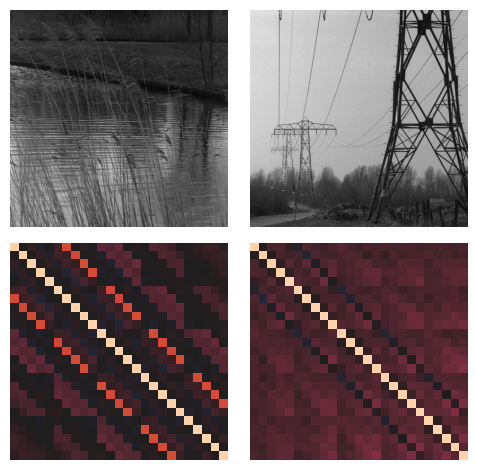

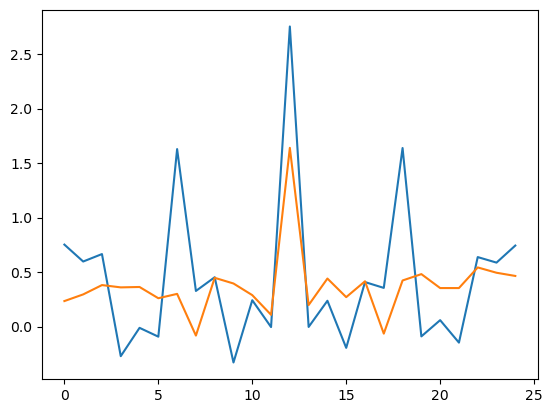

In [12]:
eps = 1E-3  # works with 5x5
# eps = 3.0E-1
# eps = 4.8E-1
cond_thresh = 20

def compute_cond(cov, eps=eps):
    return np.linalg.cond(cov + np.eye(patch_h*patch_w)*eps)

if patch_w * patch_h < 64:
    cond_nums = np.array(list(tqdm(map(compute_cond, covs), total=len(covs))))
else:
    with multiprocessing.Pool() as pool:
        cond_nums = np.array(list(tqdm(pool.imap(compute_cond, covs), total=len(covs))))

print(f'num covs w less than {cond_thresh:.2f} thresh: {np.sum(cond_nums<cond_thresh):d}')

all_covs = np.stack(covs, 0)
cond_filt_idx = np.where(cond_nums<cond_thresh)[0]
filtered_covs = all_covs[cond_filt_idx]
norm_filtered = filtered_covs

# display examples
to_plot = (3, 10)  # chosen by eye
plot_two_images(cond_filt_idx[to_plot[0]], cond_filt_idx[to_plot[1]], all_covs, files, vmin=000, vmax=2000)

# plot slice of covariance matrices
fig, ax = plt.subplots(1, 1)
N = patch_h * patch_w
ax.plot(all_covs[cond_filt_idx[to_plot[0]]][N//2])
ax.plot(all_covs[cond_filt_idx[to_plot[1]]][N//2])

In [13]:
def save_data(all_covs, cond_thresh, cond_nums, cond_filt_idx):
    data_to_save = dict(
        all_covs=all_covs,
        cond_thresh=cond_thresh,
        cond_nums=cond_nums,
        cond_filt_idx=cond_filt_idx,
    )

    import pickle
    with open('data/images/5x5_20k_3e-1.pkl', 'wb') as handle:
        pickle.dump(data_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save_data(all_covs, cond_thresh, cond_nums, cond_filt_idx)

In [14]:
import collections
from typing import List
# helpers
def normalize_frame(W, axis=0):
    """Normalize the columns of W to unit length"""
    W0 = W / np.linalg.norm(W, axis=axis, keepdims=True)
    return W0

def psd_sqrt(C):
    """Computes PSD square root"""
    d, V = np.linalg.eigh(C)
    D_sqrt = np.diag(np.sqrt(np.abs(d)))  # ensure positive eigenvals
    Csqrt = V @ D_sqrt @ V.T
    return Csqrt

def psd_square(C):
    """Computes PSD square"""
    C_squared = C.T @ C
    return C_squared

def compute_error(C, Ctarget, ord=2):
    return np.linalg.norm(C-Ctarget, ord=ord)

def get_g_opt(
    W,
    Css,
):
    """Compute optimal G."""
    N, K = W.shape
    # assert K == N * (N + 1) // 2, "W must have K = N(N+1)/2 columns."
    In = np.eye(N)
    gram_sq_inv = np.linalg.inv((W.T @ W) ** 2)
    Css_12 = psd_sqrt(Css)
    g_opt = gram_sq_inv @ np.diag(W.T @ (Css_12 - In) @ W)
    return g_opt

def smooth(x, window_size):
    return np.convolve(x, np.ones(window_size)/window_size, 'valid')

def rot2d(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def context_adaptation_experiment(
        Css_list: List[np.ndarray], 
        N: int, 
        K: int, 
        eta_w: float, 
        eta_g: float,
        batch_size: int,
        n_context_samples: int, 
        n_samples: int, 
        g0: np.ndarray,
        W0: np.ndarray, 
        alpha=1.,
        online=True,
        normalize_w=False,
        seed=None, 
        error_ord=2, 
        verbose: bool = True,
        ):
    rng = np.random.default_rng(seed)
    
    # make sources
    Css12_list = [psd_sqrt(Css) for Css in Css_list]
    n_contexts = len(Css_list)

    N, K = W0.shape
    W = W0.copy()

    In = np.eye(N)

    results = collections.defaultdict(list)

    T = n_contexts if n_context_samples == 0 else n_context_samples
    iterator = tqdm(range(T)) if verbose else range(T)
    g = g0.copy()
    # prepend and append the same 10 random contexts for plotting later
    pre_post = rng.integers(0, n_contexts, (10))
    contexts = np.concatenate([pre_post, rng.integers(0, n_contexts, (T-20, ) ), pre_post])
    for t in iterator:
        ctx = contexts[t]
        Css, Css12 = Css_list[ctx],  Css12_list[ctx]

        for _ in range(n_samples):

            if online:
                # draw sample and compute primary neuron steady-state
                s = Css12 @ rng.standard_normal((N, batch_size))  # sample data
                WGWT = (W * g[None, :]) @ W.T  # more efficient way of doing W @ np.diag(g) @ W.T
                F = np.linalg.solve(alpha*In + WGWT, In)  # more stable than inv
                r =  F @ s  # primary neuron steady-state

                # compute interneuron input/output and update g
                z = W.T @ r  # interneuron steady-state input
                n = g[:, None] * z   # interneuron steady-state output
                w_norm = np.linalg.norm(W, axis=0)**2  # weight norm
                dg = z**2 - w_norm[:, None]
                g = g + eta_g * np.mean(dg, -1)

                # update W
                rnT = r @ n.T / batch_size
                dW = rnT - W * g[None, :]
                W = W + eta_w * dW
                Crr = F @ Css @ F.T

            else:
                WG = W * g[None, :]
                WGWT = WG @ W.T  # more efficient way of doing W @ np.diag(g) @ W.T
                F = np.linalg.solve(alpha*In + WGWT, In)  # more stable than inv
                Crr = F @ Css @ F.T

                # efficient way of computing diag(W.T @ Crr @ W)
                tmp = Crr @ W
                variances = np.array([w@t for w,t in zip(W.T, tmp.T)])

                # update g + W
                dg = variances - np.linalg.norm(W, axis=0)**2
                dW = (Crr @ WG) - WG

                g = g + eta_g * dg
                W = W + eta_w * dW
                

            W = normalize_frame(W) if normalize_w else W
            results['g'].append(g)
            results['g_norm'].append(np.linalg.norm(g))
            results['W_norm'].append(np.linalg.norm(W))
            results['dg_norm'].append(np.linalg.norm(dg))
            results['dW_norm'].append(np.linalg.norm(dW))
            results['error'].append(compute_error(Crr, In, error_ord))

    results.update({
        'W0': W0,
        'W': W,
        'N': N,
        'K': K,
        'eta_w': eta_w,
        'n_samples': n_samples,
        'g0': g0,
        'W0': W0,
        'seed': seed,
    })
    return results


In [15]:
seed = 42069
rng = np.random.default_rng(seed)
N = patch_h * patch_w
K = patch_h * patch_w
alpha = 1.
eta_w = 1E-2
eta_g = 8E-2  # works with 1E-2
batch_size = 1  # batched stochastic gradient steps
n_context_samples = 512  # number of contexts seen
n_samples = 1024 # number of samples per context
error_ord = 2  # ||Crr - In||_{error_ord}  (matrix norm)
verbose = True
online = False
normalize_w = True  # normalize W after each update

W0, _ = np.linalg.qr(rng.standard_normal((N, N)))  

# optimal g for each context in Css_list
Css_list = norm_filtered
g_opts = np.array([get_g_opt(W0, Css) for Css in Css_list])
g0 = np.median(g_opts, axis=0)  # init g to median of all optimal g's

results = context_adaptation_experiment(
    Css_list,
    N,
    K,
    eta_w,  
    eta_g,
    batch_size,
    n_context_samples,
    n_samples,
    g0,
    W0,
    alpha,
    online,
    normalize_w,
    seed,
    error_ord,
    verbose,
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [16]:
from sklearn.model_selection import train_test_split
def train_test_experiment(Css_list, N, K, eta_w, n_samples, model_seed, data_seed=0, test_size=0.2, verbose=True, error_ord=2, normalize_w=True):
    Css_train, Css_test = train_test_split(Css_list, test_size=test_size, random_state=data_seed)
    results_train = fwsp.context_adaptation_experiment(Css_train, N, K, eta_w, n_samples, seed=model_seed, normalize_w=normalize_w, verbose=verbose, error_ord=error_ord)
    W0 = results_train['W']
    g0 = np.mean(results_train['g'][-100:], axis=0)

    # test set, set n_samples to 0 to automatically set n_samples to len(Cxx_test)
    results_train_fixed =  fwsp.context_adaptation_experiment(Css_train, N, K, 0., n_samples=0, W0=W0, seed=model_seed, verbose=verbose)
    results_test =  fwsp.context_adaptation_experiment(Css_test, N, K, 0., n_samples=0, W0=W0, seed=model_seed, verbose=verbose)

    # # controls
    results_test_no_gain = fwsp.context_adaptation_experiment(Css_test, N, K, 0., n_samples=0, g0=g0, W0=W0, seed=model_seed, verbose=verbose) 
    results_rand_weights = fwsp.context_adaptation_experiment(Css_test, N, K, 0., n_samples=0, g0=None, W0=None, seed=model_seed, verbose=verbose) 

    # # train weights
    # g1 = np.abs(g0)
    # tmp = fwsp.context_adaptation_experiment(Cxx_test, N, K, eta_w, n_samples, g0=g1, W0=None, seed=model_seed, verbose=verbose) 
    # results_weights_no_gain = fwsp.context_adaptation_experiment(Cxx_test, N, K, 0., n_samples=0, g0=g1, W0=tmp['W'], seed=model_seed, verbose=verbose) 

    results = {
        'train': results_train,
        'train_fixed': results_train_fixed,
        'test': results_test, 
        'test_no_gain': results_test_no_gain,
        'test_rand_weights': results_rand_weights,
        # 'test_weights_no_gain': results_weights_no_gain,
        'test_size': test_size,
    }

    return results

def _train_test_experiment_star(args):
    return train_test_experiment(*args)

In [17]:
N, K =  patch_h*patch_w, patch_h*patch_w
n_samples = 20_000
eta_w = 5E-2
eta_w = 5E-2
seed = 18
data_seed = 18
test_size = .1
n_repeats = 2048

# run experiment once on real and control contexts
with multiprocessing.Pool() as pool:
    args = ((norm_filtered, N, K, eta_w, n_samples, seed, data_seed, test_size, False) for seed in range(n_repeats))
    pbar = lambda x: tqdm(x, total=n_repeats)
    results_repeated = []
    for result in pbar(pool.imap(_train_test_experiment_star, args)):
        results_repeated.append(result)

  0%|          | 0/2048 [00:00<?, ?it/s]

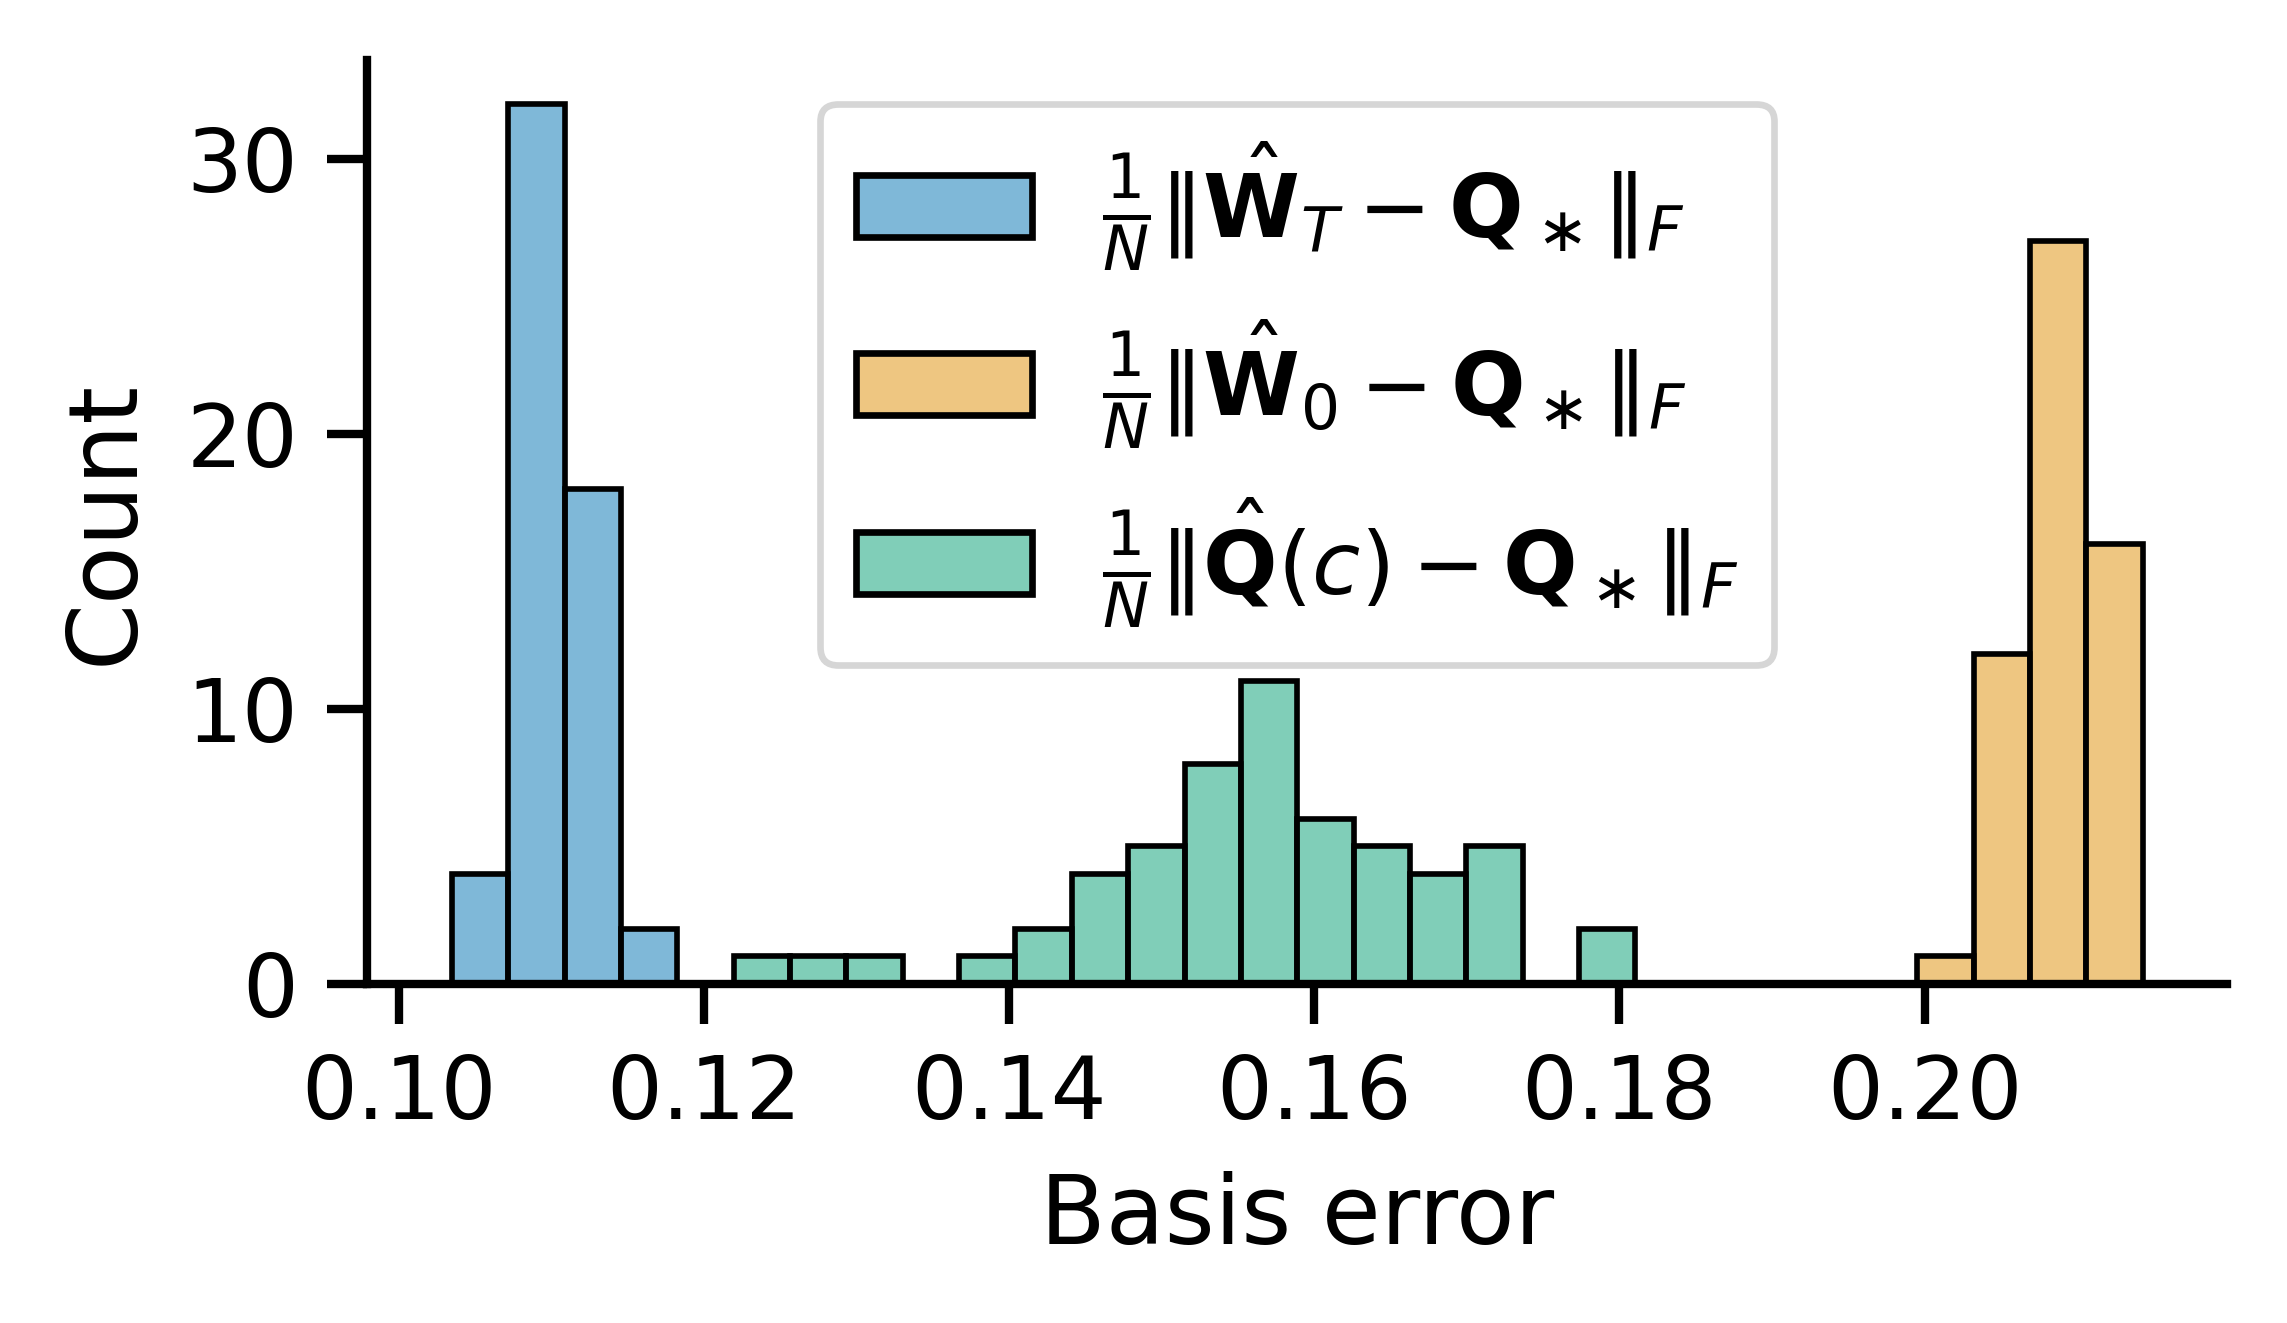

In [18]:
import frame_whitening.simulation_plasticity as fwsp

def hist_error(Css_list, results, dpi=None):
    # compare error distributions of learned W and  fixed W and Qc
    # 2D DCT matrix
    from scipy.fft import dct 
    _, Q0 = np.linalg.eigh(np.mean(Css_list, axis=0))
    Qc =[np.linalg.eigh(C)[1] for C in Css_list]
    n_contexts = len(Qc)
    Ws = [normalize_frame(result['train']['W']) for result in results[:n_contexts]]
    W0s = [normalize_frame(result['train']['W0']) for result in results[:n_contexts]]
    # fwsp.optimal_alignment()
    N = Q0.shape[0]
    F = dct(np.eye(N), norm='ortho')

    qc_error = [np.linalg.norm(fwsp.optimal_alignment(Q, Q0) - Q0, 'fro')/N for Q in Qc]
    w_error = [np.linalg.norm(fwsp.optimal_alignment(W, Q0) - Q0, 'fro')/N for W in Ws]
    w0_error = [np.linalg.norm(fwsp.optimal_alignment(W0, Q0) - Q0, 'fro')/N for W0 in W0s]
    dct_error = [np.linalg.norm(fwsp.optimal_alignment(W, F) - F, 'fro')/N for W in Ws]

    to_plot = {r'$\frac{1}{N}\Vert \hat{\bf W}_T - {\bf Q}_\ast \Vert_F$': w_error, 
              r'$\frac{1}{N}\Vert \hat{\bf W}_0 - {\bf Q}_\ast\Vert_F$': w0_error, 
              r'$\frac{1}{N}\Vert \hat{\bf Q}(c) - {\bf Q}_\ast \Vert_F$': qc_error,
            #   r'$\Vert {\bf W}_T - {\bf Q}_{DCT} \Vert_F$': dct_error,
              }

    df = pd.DataFrame(to_plot)
    with sns.plotting_context('paper', font_scale=1.2):
        fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=dpi)
        sns.histplot(data=df, bins=30,alpha=.5, ax=ax, palette='colorblind')
        # sns.kdeplot(data=df, alpha=.5, ax=ax, palette='colorblind')
        ax.set(xlabel='Basis error', ylabel='Count')
        sns.despine()


hist_error(norm_filtered, results_repeated, dpi=600)

In [19]:
def verify_eigenvectors(results):
    """checks if eigenvectors of learned W matches the avg eigenvectors of the test set"""

    W = results['train']['W']
    g = results['train']['g'][-1]
    # g = np.mean(g[-1], axis=0) 

    tmp0 = np.linalg.inv(np.eye(N) + W @ np.diag(g) @ W.T)
    tmp0 = np.eye(N) + W @ np.diag(g) @ W.T
    _, Q = np.linalg.eigh(tmp0)
    tmp0 /= np.trace(tmp0)

    seed = results['train']['seed']
    test_size = results['test_size']
    Css_train, Css_test = train_test_split(norm_filtered, test_size=test_size, random_state=seed)
    
    # Cov = np.mean([C for C in Css_train],0)
    Cov = np.mean([fw.psd_sqrt(C) for C in Css_train], 0)
    Cov = Css_train[-1]

    d, V = np.linalg.eigh(Cov)

    # tmp = V @ np.diag(1/np.sqrt(np.abs(d))) @ V.T
    tmp = V @ np.diag(np.sqrt(np.abs(d))) @ V.T
    tmp /= np.trace(tmp)
    _, V = np.linalg.eigh(tmp)

    fig, ax = plt.subplots(1, 3, sharex='all', sharey='all', figsize=(12, 4), dpi=600)

    MAX = np.max([tmp, tmp0])
    MAX = None
    if MAX:
        ax[0].imshow(tmp, vmin=-MAX, vmax=MAX, cmap='icefire')
        ax[1].imshow(tmp0, vmin=-MAX, vmax=MAX, cmap='icefire')
    else:
        ax[0].imshow(tmp, cmap='icefire')
        ax[1].imshow(tmp0, cmap='icefire')

    ax[2].imshow(Q.T@V,  cmap='icefire')
    ax[0].set(title=r'$\mathbb{E}_{c}[{\bf \Sigma}_c]={\bf VDV}^\top$', xticks=[], yticks=[])
    ax[1].set(title=r'$({\bf I}_N + {\bf W}_T\operatorname{diag}({\bf g}_c){\bf W}_T^\top)={\bf QSQ}^\top$', xticks=[], yticks=[])
    ax[2].set(title=r'${\bf Q}^\top {\bf V}$')
    sns.despine(bottom=True, left=True)
    fig.tight_layout()

# verify_eigenvectors(results_repeated[0])

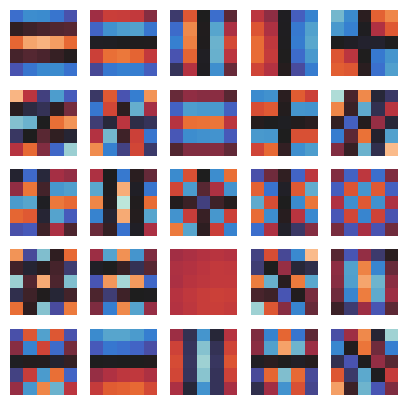

In [20]:
def plot_filters(results, nrows, ncols, figsize, cmap='icefire'):
    # plot all hxw * hxw filters
    W = results['train']['W']
    n2, k = W.shape
    h, w = int(np.sqrt(n2)), int(np.sqrt(n2))
    # fig, ax = plt.subplots(int(np.sqrt(k)), int(np.sqrt(k)), figsize=(8, 8), sharex='all', sharey='all')
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, sharex='all', sharey='all')
    ax = ax.ravel()
    MAX = np.max(np.abs(W))
    for i in range(k):
        w0 = W[:, i].reshape((h, w))
        # ax[i].imshow(W[:, i].reshape((h, w)), cmap='icefire', vmin=-MAX, vmax=MAX)
        # MAX = np.max(np.abs(w0))
        ax[i].imshow(w0, cmap=cmap, vmin=-MAX, vmax=MAX)
        ax[i].axis('off')
    # fig.tight_layout()
    for i in range(k, nrows*ncols):
        ax[i].axis('off')
    sns.despine(bottom=True, left=True)

# plot_filters(results_repeated[18], 3, 9, figsize=(9, 3))
plot_filters(results_repeated[18], 5, 5, figsize=(5, 5), cmap='icefire')

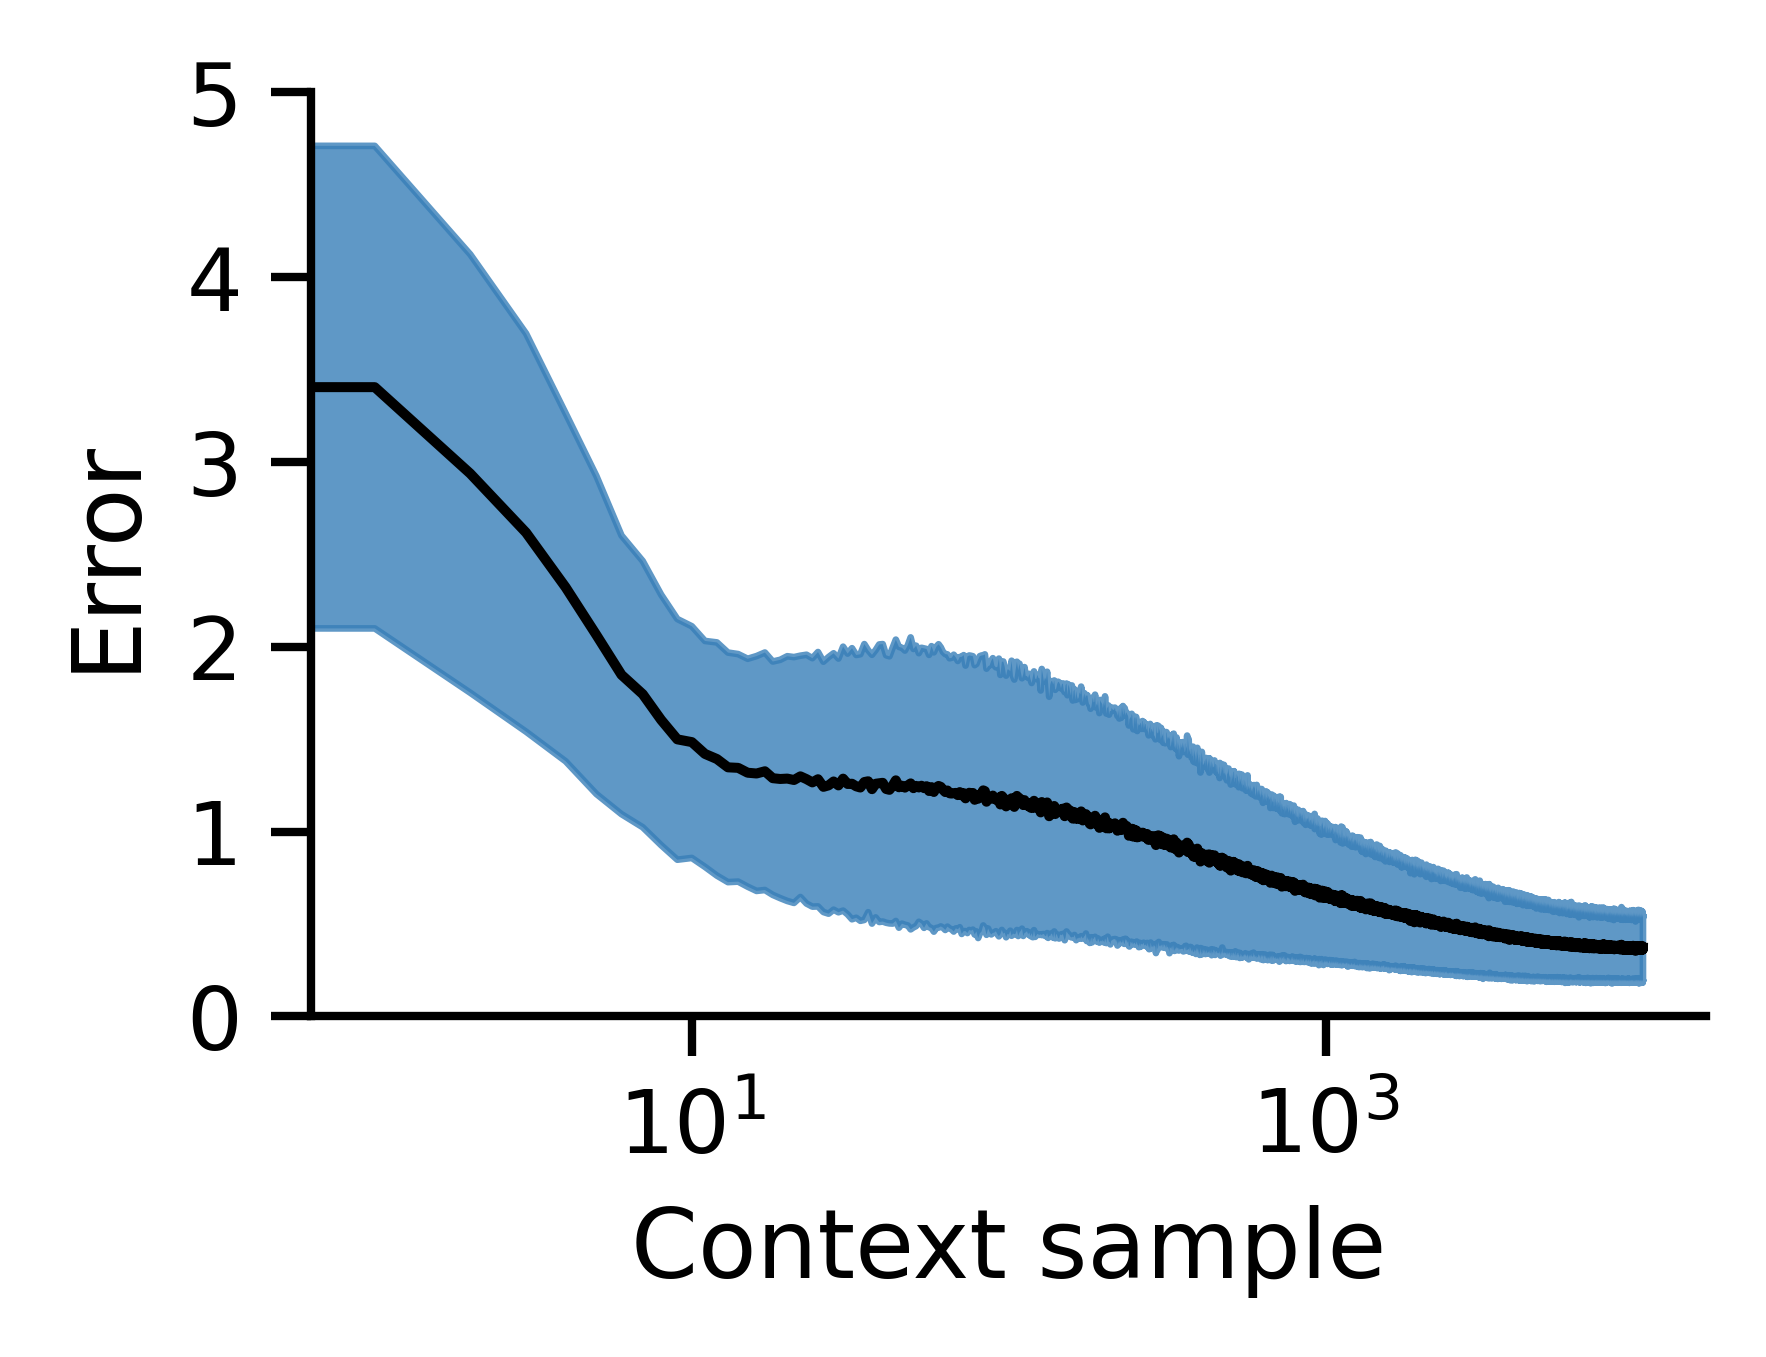

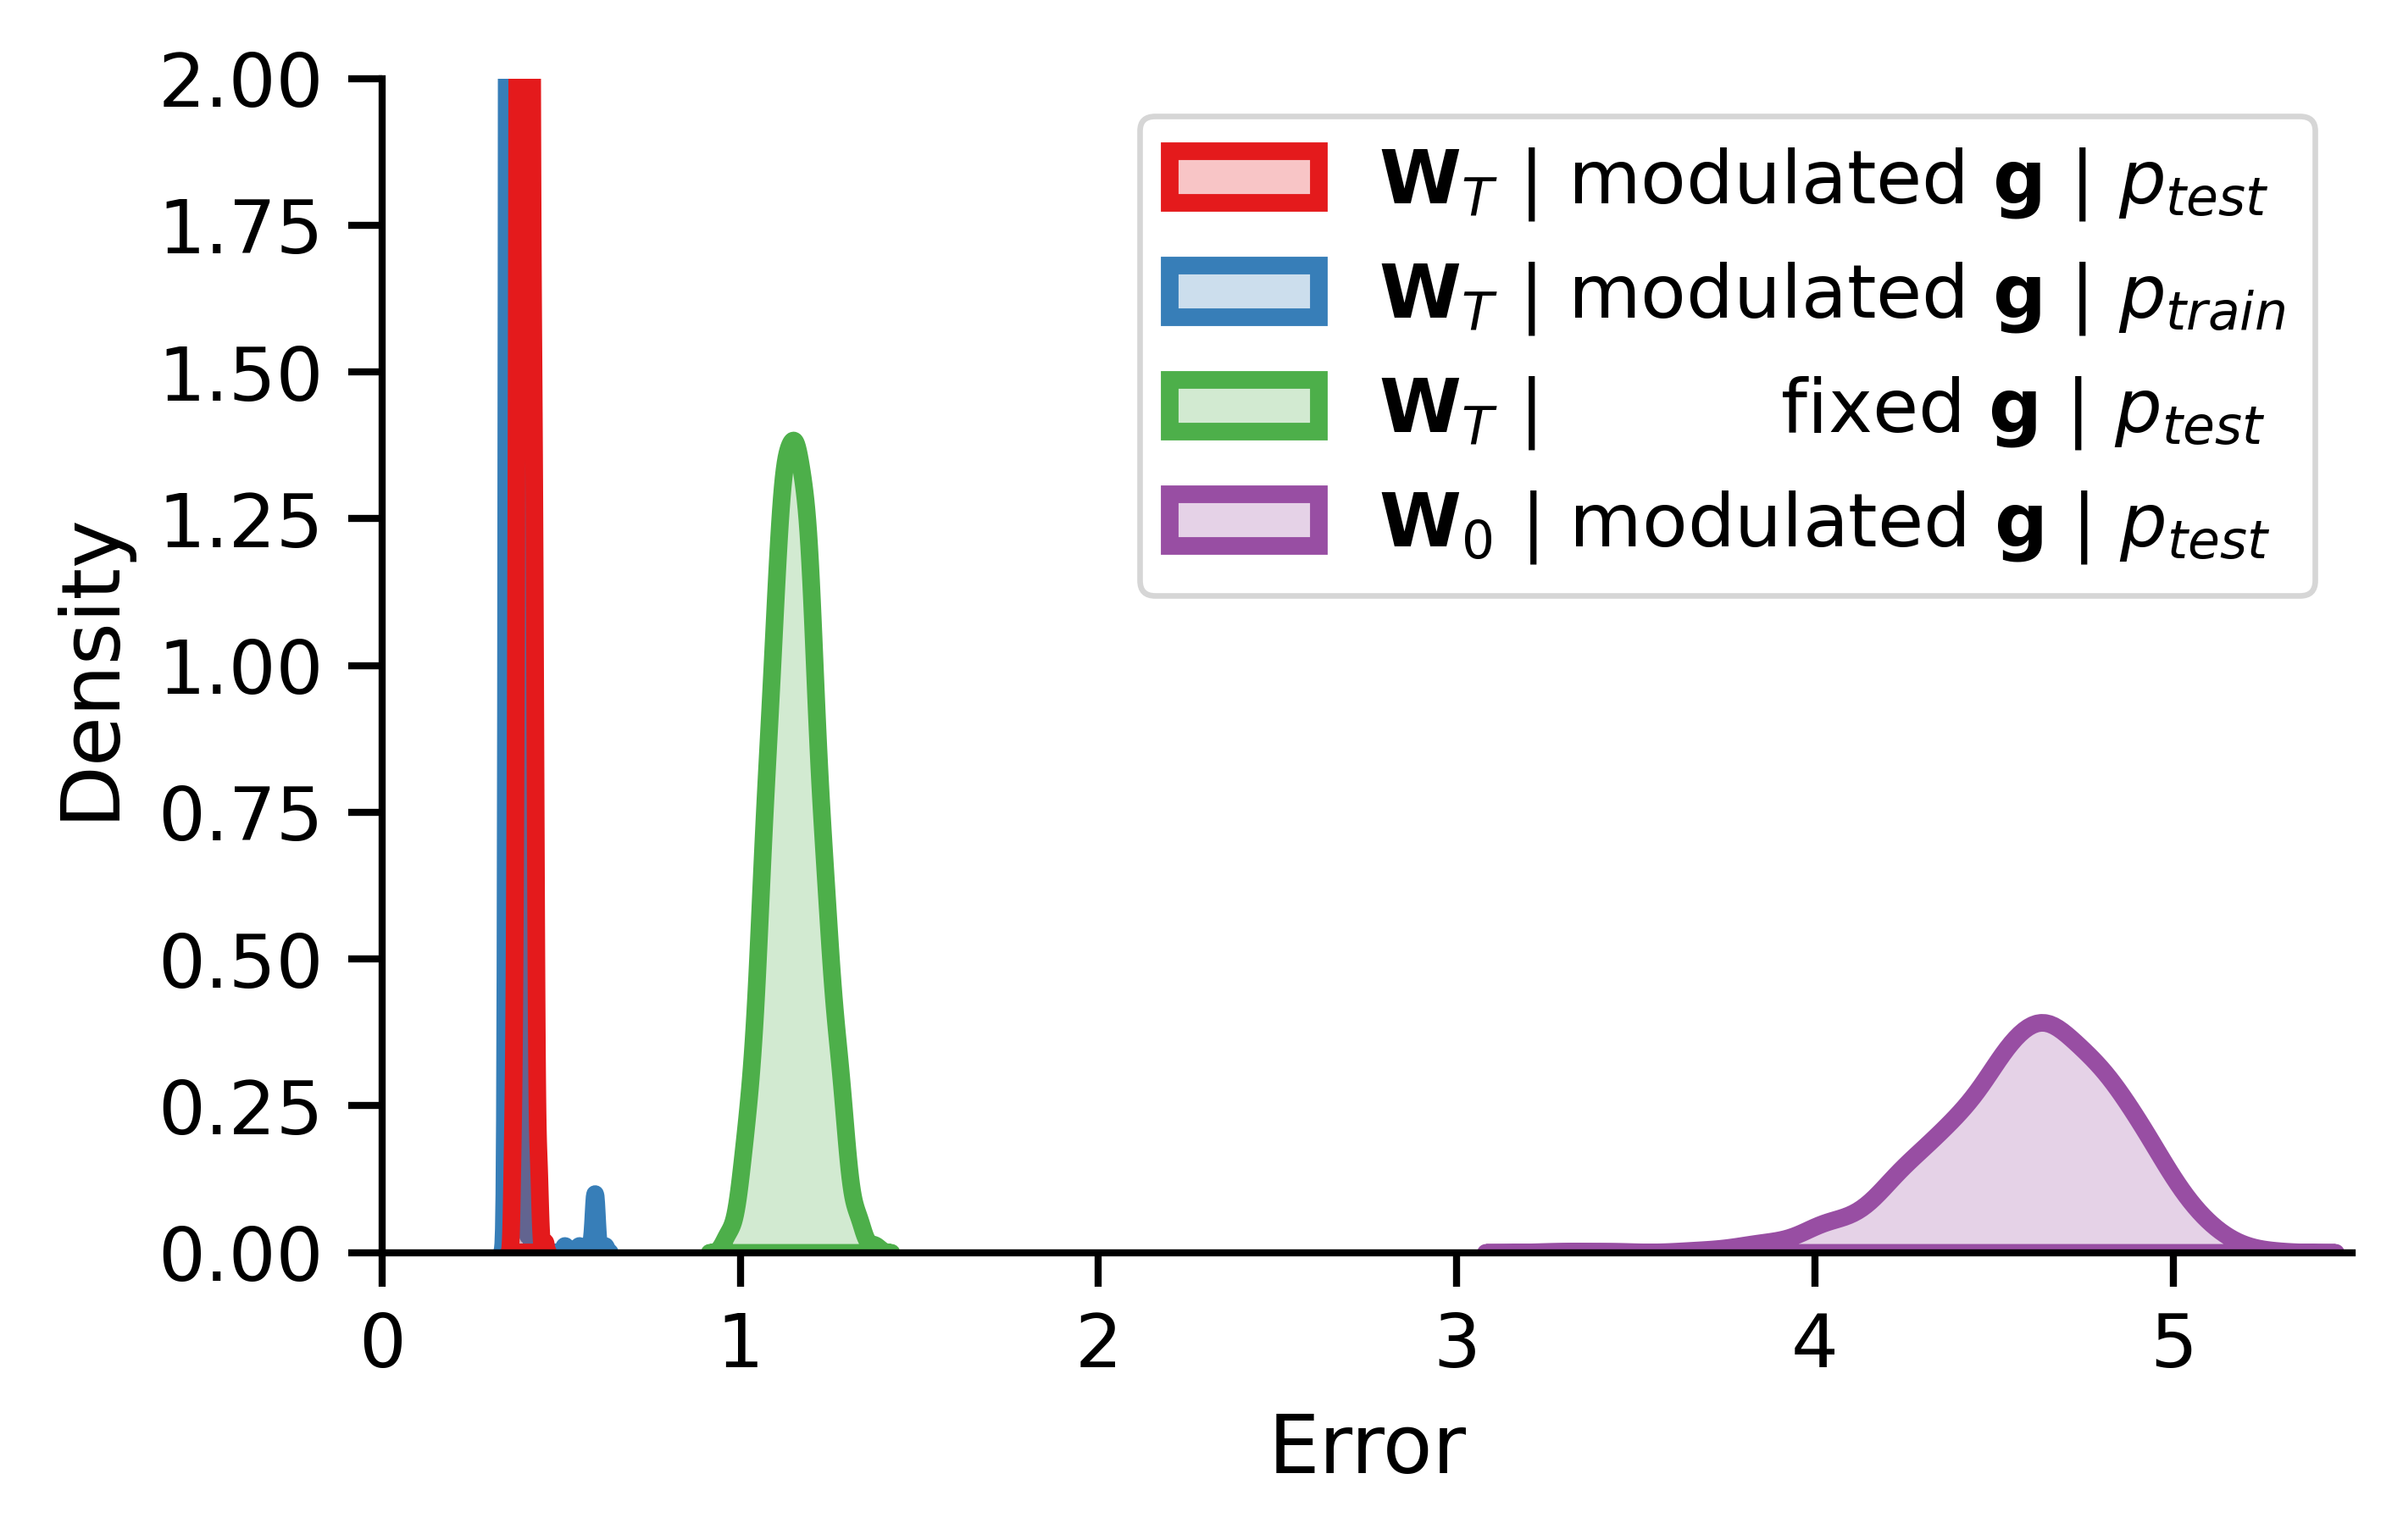

In [21]:
import collections
import pandas as pd
def plot_repeated_results(results_repeated, dpi):

    with sns.plotting_context('paper', font_scale=1.2):
        fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=dpi)
        mu = np.mean([results['train']['error'] for results in results_repeated], 0)[:10_000]
        sig = np.std([results['train']['error'] for results in results_repeated], 0)[:10_000]
        T = len(mu)
        tt = np.linspace(0, T/1, T)
        ax.plot(tt, mu, 'k')
        cols = sns.color_palette('Set1',2)
        ax.fill_between(tt, mu-sig, mu+sig, alpha=.8, color=cols[1])
        ax.set(yscale='linear', xscale='log', xlabel='Context sample', ylabel='Error', ylim=(0, 5.))
        sns.despine()

        # plot avg of last 1000 samples
        dict_plot = collections.defaultdict(list)
        keys = [ 'test', 'train_fixed', 'test_no_gain', 'test_rand_weights']
        labels = [
        r'${\bf W}_T$ | modulated ${\bf g}$ | $p_{test}$',
        r'${\bf W}_T$ | modulated ${\bf g}$ | $p_{train}$',
        r'${\bf W}_T$ |          fixed ${\bf g}$ | $p_{test}$',
        r'${\bf W}_0$ | modulated ${\bf g}$ | $p_{test}$',
        ]

        for i, key in enumerate(keys):
            dict_plot[labels[i]].extend([np.mean(results_repeated[i][key]['error']) for i in range(len(results_repeated))])

        fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=dpi)
        df = pd.DataFrame(dict_plot)
        # sns.histplot(df, bins=50, stat='probability', multiple='dodge', ax=ax, legend=True, palette='Set1', log_scale=(False, False))
        # seaborn legend go on bottom right
        axs = sns.kdeplot(df, fill=True, ax=ax, legend=True, palette='Set1', log_scale=(False, False), linewidth=2.5)
        # sns.move_legend(axs, "upper center")
        # axs.legend(fontsize=8)
        ax.set(xlabel='Error', xlim=(0, 5.5), ylim=(0, 2.))
        sns.despine()

plot_repeated_results(results_repeated, dpi=600)

In [22]:
import itertools

def error_varying_k_experiment(max_k, n_repeats):
    with multiprocessing.Pool() as pool:
        k_seed = itertools.product(range(0, max_k+1), range(n_repeats))
        test_size = 0.1
        n_samples = 50_000
        # generator
        iter_args =  ((norm_filtered, N, k, eta_w, n_samples, seed, seed, test_size, False) for k, seed in k_seed)

        results = []
        n_iters = max_k * n_repeats
        pbar = lambda x: tqdm(x, total=n_iters)
        for result in pbar(pool.imap_unordered(_train_test_experiment_star, iter_args)):
            results.append(result)
    
    # aggregate
    results_k_train = {(result['train']['K'], result['train']['seed']): result['train']['error'] for result in results}
    results_k_test = {(result['test']['K'], result['test']['seed']): result['test']['error'] for result in results}
    return results_k_train, results_k_test

results_k_train, results_k_test = error_varying_k_experiment(max_k=25*13, n_repeats=10)

  0%|          | 0/3250 [00:00<?, ?it/s]

9.0 9.0 1.3759600911837627e-15 0.0


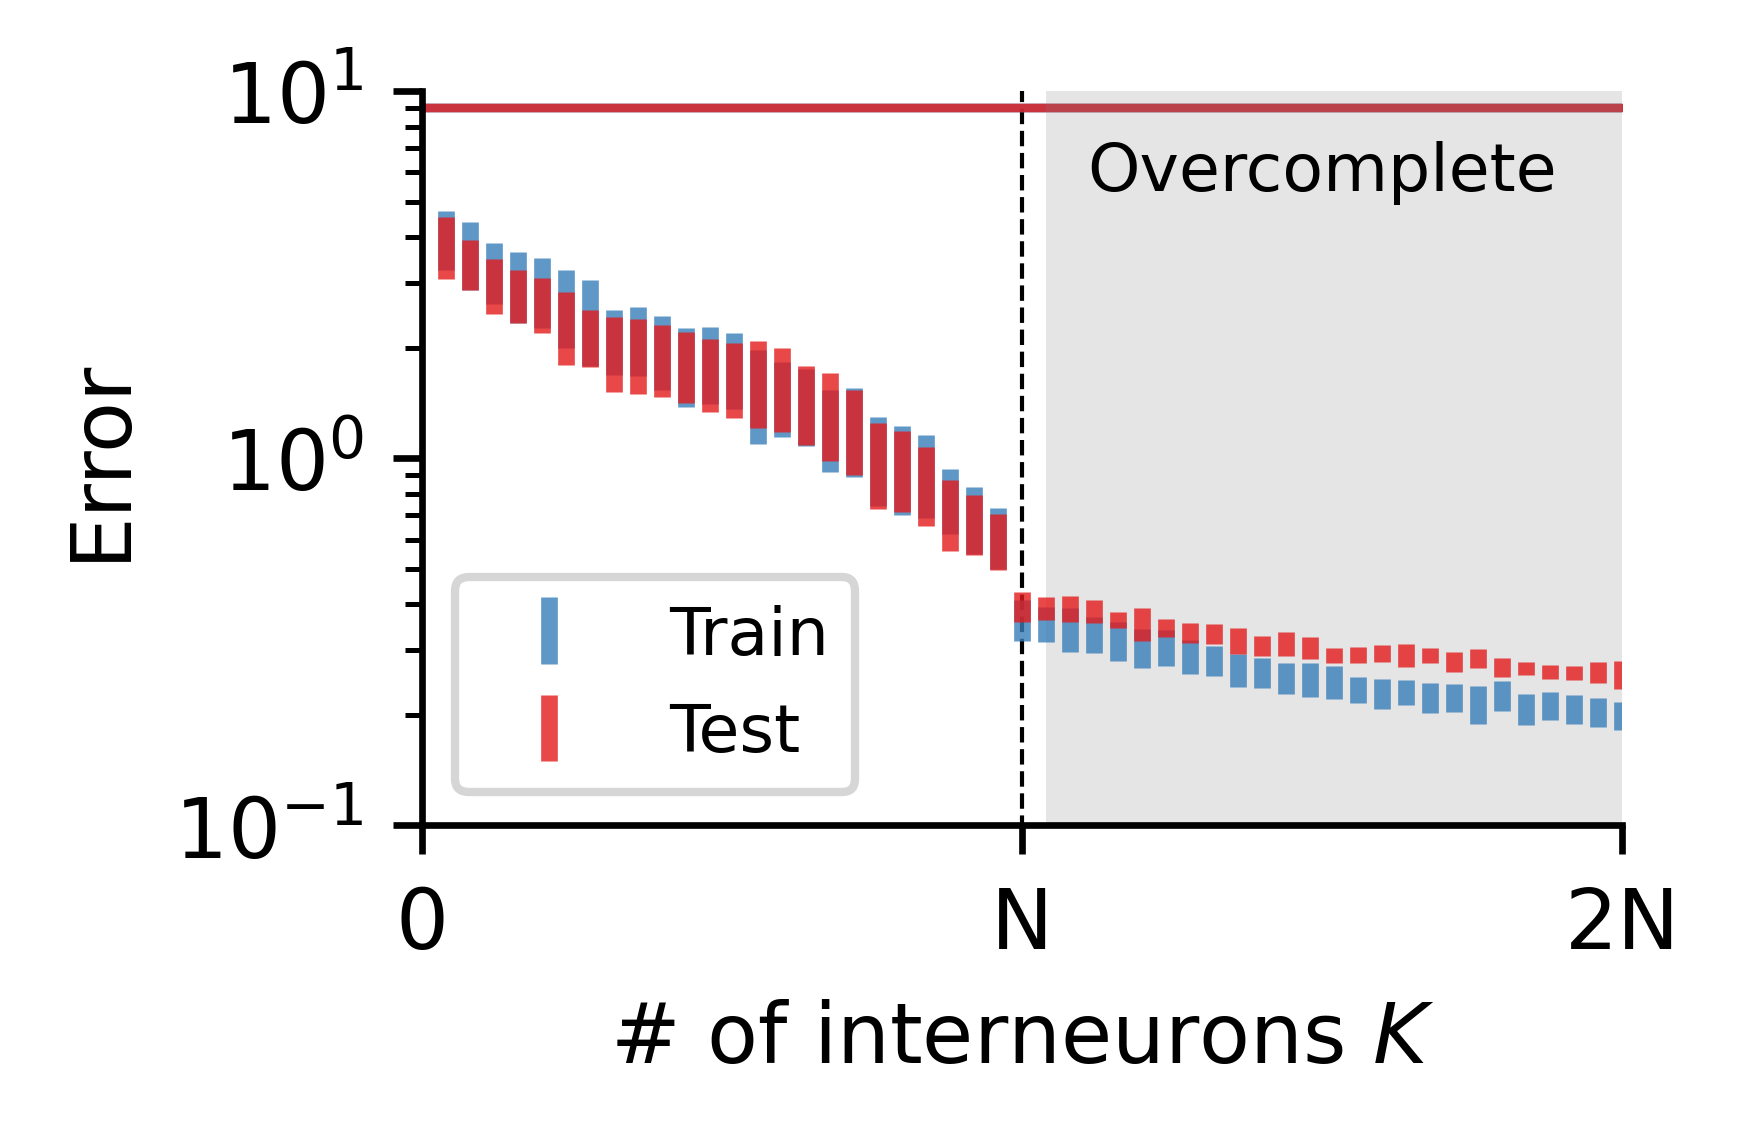

In [23]:
import collections

def plot_experiment_k(results_k_train, results_k_test, dpi=None):
    # aggregate across all runs
    aggregated_train = collections.defaultdict(list)
    aggregated_test = collections.defaultdict(list)

    for key in results_k_train.keys():
        k, _ = key
        aggregated_train[k].append(results_k_train[key])
        aggregated_test[k].append(results_k_test[key])

    aggregated_train = {k: np.mean(v, axis=0) for k, v in aggregated_train.items()}
    aggregated_test = {k: np.mean(v, axis=0) for k, v in aggregated_test.items()}

    window_size = 50
    # N = 16
    # T = 100_000
    # k_max = len(aggregated_train)
    k_max = 50
    last_error_train = np.array([np.mean(aggregated_train[k][-window_size:]) for k in range(1, k_max+1)])
    last_error_test = np.array([np.mean(aggregated_test[k][-window_size:]) for k in range(1, k_max+1)])

    # stdevs
    q_train = np.array([np.std(aggregated_train[k][-window_size:],axis=0) for k in range(1, k_max+1)])
    q_test = np.array([np.std(aggregated_test[k][-window_size:], axis=0) for k in range(1, k_max+1)])

    cols = sns.color_palette('Set1',2)
    fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=dpi)
    ax.errorbar(range(1, k_max+1), last_error_train, yerr=q_train, fmt='none', markeredgewidth=0., linewidth=2, color=cols[1], alpha=0.8, label='Train')
    ax.errorbar(range(1, k_max+1), last_error_test, yerr=q_test, fmt='none', markeredgewidth=0., linewidth=2, color=cols[0], alpha=.8, label='Test')

    # fill rectangle from N+1 to k_max and 0 to max error
    from matplotlib.patches import Rectangle
    rect = Rectangle((N+1, 0), k_max-N, 10, facecolor='gray', alpha=0.2)
    ax.vlines(N, 0, 10, color='k', linestyle='--', lw=.5, zorder=-1)
    # draw dashed hline for when K=0, from 0 to k_max
    m0_train = np.mean(aggregated_train[0][-window_size:])
    m0_test = np.mean(aggregated_test[0][-window_size:])
    q0_train = np.std(aggregated_train[0][-window_size:], axis=0)
    q0_test = np.std(aggregated_test[0][-window_size:], axis=0)

    print(m0_train, m0_test, q0_train, q0_test)
    ax.fill_between(range(0, k_max+1), m0_train-q0_train, m0_train+q0_train, color=cols[1], alpha=0.8)
    ax.fill_between(range(0, k_max+1), m0_test-q0_test, m0_test+q0_test, color=cols[0], alpha=0.8)

    ax.add_patch(rect)
    # add text saying "Overcomplete" in middle of rectangle
    ax.text(N + (k_max-N)/2, 6, 'Overcomplete', ha='center', va='center', fontsize=8, color='k')

    ax.set(ylim=(1E-1, 10), xlabel=r'# of interneurons $K$', ylabel='Error', xscale='linear', yscale='log', xlim=(0, 50), xticks=(0, 25, 50), xticklabels=('0', 'N', '2N'))
    # ax.set(xlim=(0, 10))
    ax.legend(loc='lower left', fontsize=8, frameon=True)
    sns.despine()
    fig.tight_layout()
    # remove white space
    fig.subplots_adjust(wspace=0, hspace=0)

plot_experiment_k(results_k_train, results_k_test, dpi=600)